# Investing with 'FACTOR INVESTING'

## What is the CAPM?

**Capital Asset Pricing Model** CAPM is a financial model to evaluate the expected return of an asset. It provides a framework for understanding the relationship between the asset's risk and its expected return.

- CAPM considers market risk to be the primary determinant of an asset's expected return.
- Market risk is measured by beta, which represents the asset's sensitivity to market movements.
- The CAPM formula is: E(X) = risk free rate + Beta * (Market Return - Risk Free Rate)
- The **risk free rate** represents the return on a risk free investment, for example; government bonds.
- The CAPM model helps investors determine if the asset value is undervalued or overvalued. 







## What is the Fama-French Three-Factor Model

**The Fama-French Three Factor Model** is an extension of the CAPM. This model tries to explain expected returns of an asset by adding three more additional factors.

**Key Factors of Fama-French**
- Market Risk
- Size - Measures the difference in returns between small-cap and large-cap stocks
- Value - Measures the difference in returns betweeen high book-to-market ratio and low book-to-market ratio stocks

Fama French Model: E(X) = risk free rate + Beta * (Market Return - risk free rate) + size + value

By using the additional three factors the Fama-French model aims to better explain the cross-sectional variation in asset returns and provide a more comprehensive approach to asset pricing beyond CAPM's market risk consideration. 


## Cap - Weighted Benchmarks

Default approach is to use a **Cap-Weighted Index** as a *Benchmark* for **Active** or **Passive** managers.

But Cap-Weighted Indices are very inefficient. They tend to be **heavily concentrated** poorly diversified portfolios.

CW Indicies Provide an inefficient diversification of unrewarded and specific risks.

**Smart(Weighted) Benchmarks** have been introduced to fix the problem.

For example: 
- Equally-Weighted Benchmarks
- Minimum Variance Benchmarks
- Risk Parity Benchmarks

In [2]:
import pandas as pd 
brka_d = pd.read_csv('data/brka_d_ret.csv', parse_dates = True, index_col = 0)
brka_d.head()

,BRKA
DATE,
1990-01-02,-0.005764
1990-01-03,0.000000
1990-01-04,0.005797
1990-01-05,-0.005764
1990-01-08,0.000000


Next, we need to convert these to monthly returns. The simplest way to do so is by using the `.resample` method, which allows you to run an aggregation function on each group of returns in a time series. We'll give it the grouping rule of 'M' which means _monthly_ (consult the `pandas`) documentation for other codes)

We want to compound the returns, and we already have the `compound` function in our toolkit, so let's load that up now, and then apply it to the daily returns.

In [3]:
import risk_kit as rk

%load_ext autoreload
%autoreload 2

brka_m = brka_d.resample('M').apply(rk.compound).to_period('M')
brka_m.head()

,BRKA
DATE,
1990-01,-0.140634
1990-02,-0.030852
1990-03,-0.069204
1990-04,-0.003717
1990-05,0.067164


In [4]:
brka_m.to_csv('brka_m.csv')

In [5]:
fff = rk.get_fff_returns()
fff.head()

,Mkt-RF,SMB,HML,RF
1926-07,0.0296,-0.0230,-0.0287,0.0022
1926-08,0.0264,-0.0140,0.0419,0.0025
1926-09,0.0036,-0.0132,0.0001,0.0023
1926-10,-0.0324,0.0004,0.0051,0.0032
1926-11,0.0253,-0.0020,-0.0035,0.0031


Next, we need to decompose the observed BRKA 1990-May 2012 as in Ang(2014) into the portion that's due to the market and the rest that is not due to the market, using the CAPM as the explanatory model.

i.e.

$$ R_{brka,t} - R_{f,t} = \alpha + \beta(R_{mkt,t} - R_{f,t}) + \epsilon_t $$

We can use the `stats.api` for the linear regression as follows:

In [6]:
import statsmodels.api as sm 
import numpy as np

brka_excess = brka_m["1990":"2012-05"] - fff.loc['1990':'2012-05', ['RF']].values
mkt_excess = fff.loc['1990': '2012-05', ['Mkt-RF']]
exp_var = mkt_excess.copy()
exp_var['Constant'] = 1
lm = sm.OLS(brka_excess, exp_var).fit()

In [7]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     48.45
Date:                Sun, 23 Jul 2023   Prob (F-statistic):           2.62e-11
Time:                        23:39:11   Log-Likelihood:                 388.47
No. Observations:                 269   AIC:                            -772.9
Df Residuals:                     267   BIC:                            -765.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.5402      0.078      6.961      0.000       0.387       0.693
Constant       0.0061      0.004      1.744      0.082      -0.001       0.013
==============================================================================
Omnibus:                       45.698   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.573
Skew:                           0.825   Prob(JB):                     5.33e-23
Kurtosis:                       5.535   Cond. No.                         22.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
exp_var['Value'] = fff.loc['1990':'2012-05', ['HML']]
exp_var['Size'] = fff.loc['1990': '2012-05', ['SMB']]
exp_var.head()

,Mkt-RF,Constant,Value,Size
1990-01,-0.0785,1,0.0087,-0.0129
1990-02,0.0111,1,0.0061,0.0103
1990-03,0.0183,1,-0.0290,0.0152
1990-04,-0.0336,1,-0.0255,-0.0050
1990-05,0.0842,1,-0.0374,-0.0257


In [9]:
lm = sm.OLS(brka_excess, exp_var).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     36.06
Date:                Sun, 23 Jul 2023   Prob (F-statistic):           1.41e-19
Time:                        23:39:11   Log-Likelihood:                 412.09
No. Observations:                 269   AIC:                            -816.2
Df Residuals:                     265   BIC:                            -801.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.6761      0.074      9.155      0.000       0.531       0.821
Constant       0.0055      0.003      1.679      0.094      -0.001       0.012
Value          0.3814      0.109      3.508      0.001       0.167       0.595
Size          -0.5023      0.101     -4.962      0.000      -0.702      -0.303
==============================================================================
Omnibus:                       42.261   Durbin-Watson:                   2.146
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.954
Skew:                           0.904   Prob(JB):                     1.75e-15
Kurtosis:                       4.671   Cond. No.                         37.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
lm = rk.regress(brka_excess, exp_var, alpha = False)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     36.06
Date:                Sun, 23 Jul 2023   Prob (F-statistic):           1.41e-19
Time:                        23:39:11   Log-Likelihood:                 412.09
No. Observations:                 269   AIC:                            -816.2
Df Residuals:                     265   BIC:                            -801.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.6761      0.074      9.155      0.000       0.531       0.821
Constant       0.0055      0.003      1.679      0.094      -0.001       0.012
Value          0.3814      0.109      3.508      0.001       0.167       0.595
Size          -0.5023      0.101     -4.962      0.000      -0.702      -0.303
==============================================================================
Omnibus:                       42.261   Durbin-Watson:                   2.146
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.954
Skew:                           0.904   Prob(JB):                     1.75e-15
Kurtosis:                       4.671   Cond. No.                         37.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Performing Sharpe Style Analysis

The key to obtaining the weights is our old friend, the quadriatic optimizer. We are asking the optimizer to find the weights that minimizes the square of the difference between the observed series and the returns of a benchmark portfolio that holds the explanatory building blocks in those same weights. This is equivalent to minimizing the _tracking error_ between the two return series.

A **low** tracking error indicates that the portofilio closely follows the benchmark, which generally considered desirable for investments aiming to replicate the benchmark's returns. On the other hand, a **higher** tracking error suggests that the portfolio's performance significantly differs from the benchmark, indicating active management or deviation from the benchmark's performance.

In [11]:
ind = rk.get_ind_returns()['2000':]

Let's construct a manager that invests in 30% Beer, 50% in Smoke and 20% in other things that have an average return of 0% and an annualized vol of 15%

In [12]:
mgr_r = 0.3*ind["Beer"] + 0.5*ind["Smoke"] + 0.2*np.random.normal(scale=0.15/(12**.5), size=ind.shape[0])

Now, assume we knew absolutely nothing about this manager and all we observed was the returns. How could we tell what she was invested in?

In [13]:
weights = rk.style_analysis(mgr_r, ind)*100

<Axes: >

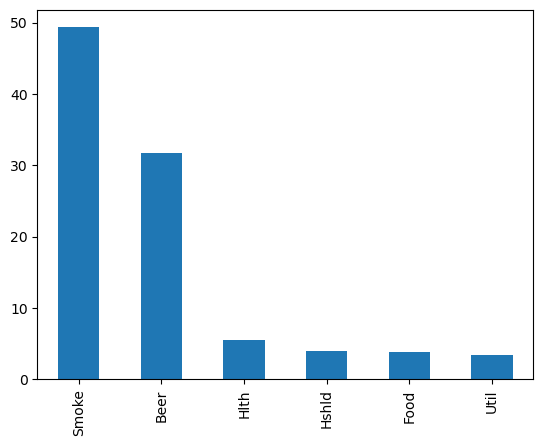

In [14]:
weights.sort_values(ascending=False).head(6).plot.bar()

In [15]:
coeffs = rk.regress(mgr_r, ind).params*100
coeffs.sort_values().head()

Cnstr   -2.717644
FabPr   -2.459833
Oil     -2.235809
Chems   -1.652253
Hshld   -1.376389
dtype: float64

<Axes: >

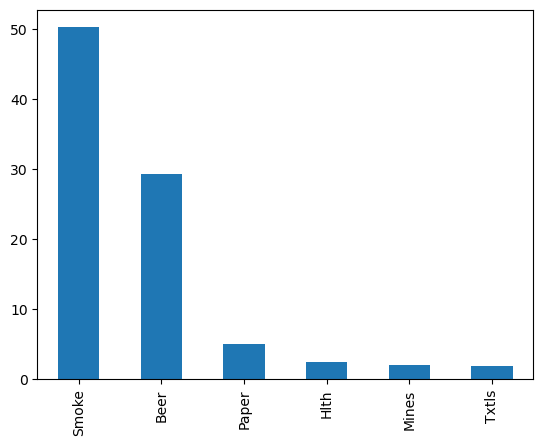

In [16]:
coeffs.sort_values(ascending=False).head(6).plot.bar()

# Warning: Potential Misuse of Style Analysis

Style Analysis works best when the explanatory indices are in fact a good specification of what is happening. For instance, it usually gives you very useful and revealing insight if you use a stock market index (such as SPY) and other broad indices, ETFs or mutual funds (such as a Value Fund, a Growth Fund, an International Fund, a Bond Fund etc).

Part of the skill in extracting meaningful results is to pick the right set of explanatory variables.

However, a part of the challenge with Style Analysis is that it will _always_ return a portfolio. Although it is possible to develop a figure of merit of fit quality similar to an $R^2$, it will still always give you an answer, however unreasonable it might be, and it's not always obvious how much one can rely on the result.

For instance, we can try and extract the major industries that Buffer invested in since 2000 as follows:

In [17]:
brka_m = pd.read_csv("data/brka_m.csv", index_col=0, parse_dates=True).to_period('M')
brka_m.head()

,BRKA
DATE,
1990-01,-0.140634
1990-02,-0.030852
1990-03,-0.069204
1990-04,-0.003717
1990-05,0.067164


In [18]:
mgr_r_b = brka_m['2000':]['BRKA']
weights_b = rk.style_analysis(mgr_r_b, ind)
weights_b.sort_values(ascending=False).head(6).round(4)*100

Food     41.35
Fin      17.61
Meals    12.11
Other    11.03
Util      7.19
Clths     5.99
dtype: float64

In [19]:
import yfinance as yf
tickers = ["^GSPC", "^IXIC","SPYG","OEF","SLY"]

data = yf.download(tickers, start = "2018-01-01", end = "2023-07-31", interval="1mo")

monthly_returns = data['Adj Close'].pct_change()

monthly_returns = monthly_returns.dropna()

monthly_returns.head()


[*********************100%***********************]  5 of 5 completed


,OEF,SLY,SPYG,^GSPC,^IXIC
Date,,,,,
2018-02-01,-0.038541,-0.037700,-0.021204,-0.038947,-0.018683
2018-03-01,-0.039341,0.013643,-0.031774,-0.026884,-0.028813
2018-04-01,0.007905,0.012407,0.004934,0.002719,0.000399
2018-05-01,0.027150,0.066771,0.043465,0.021608,0.053189
2018-06-01,0.000418,0.006753,0.002283,0.004842,0.009161


In [20]:

exp = monthly_returns[:]["^IXIC"]
weights_y = rk.style_analysis(exp, ind)
weights_y.sort_values(ascending=False).head(6).round(4)*100

Food     3.33
Beer     3.33
Fin      3.33
Meals    3.33
Rtail    3.33
Whlsl    3.33
dtype: float64

# Comparing EW and CapWeighted Portfolios

Load the EW and VW versions of the returns of the industry portfolios.

In [22]:
ind_cw = rk.get_ind_returns(ew = False)
ind_ew = rk.get_ind_returns(ew=True)

TypeError: get_ind_returns() got an unexpected keyword argument 'ew'

In [ ]:
sr = pd.DataFrame({"CW": rk.sharpe_ratio(ind_cw["1945":], 0.03, 12), "EW": rk.sharpe_ratio(ind_ew["1945":], 0.03, 12)})

<Axes: >

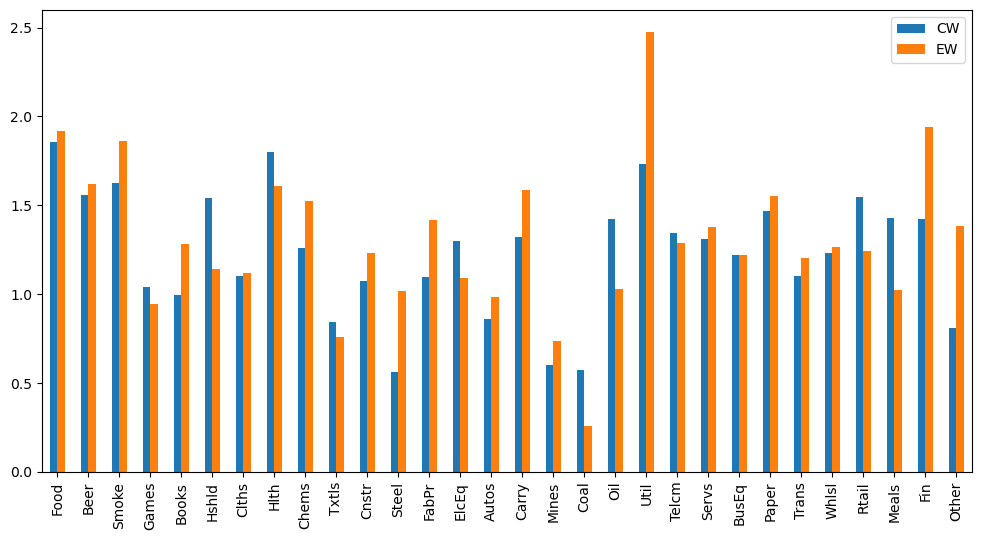

In [ ]:
sr.plot.bar(figsize=(12, 6))

In [ ]:
(sr['EW'] > sr["CW"]).sum()*100/sr.shape[0]

63.333333333333336

Text(0.5, 1.0, 'Average Trailing 5 year Sharpe Ratio across 30 Industry Portfolios 1945-2018')

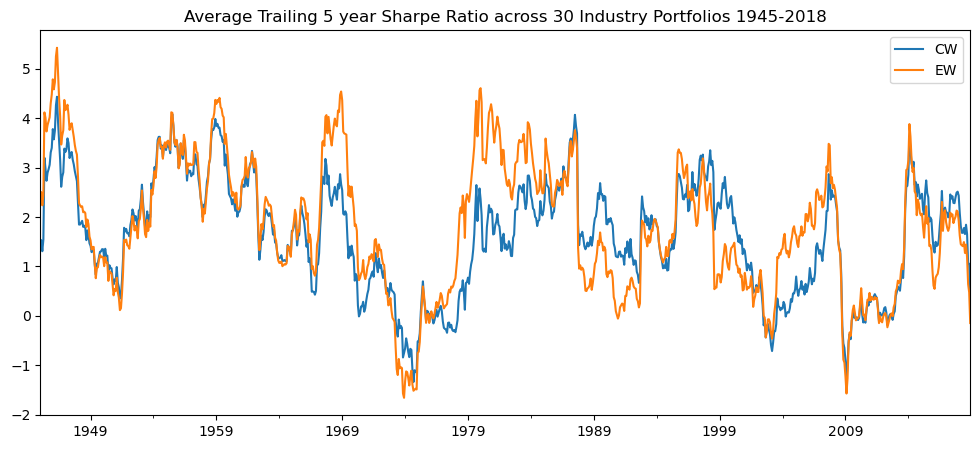

In [ ]:
ax = ind_cw.rolling(60).apply(rk.sharpe_ratio, raw=True, kwargs={"riskfree_rate":0.03, "periods_per_year":12}).mean(axis=1)["1945":].plot(figsize=(12,5), label="CW", legend=True)
ind_ew.rolling(60).apply(rk.sharpe_ratio, raw=True, kwargs={"riskfree_rate":0.03, "periods_per_year":12}).mean(axis=1)["1945":].plot(ax=ax, label="EW", legend=True)
ax.set_title("Average Trailing 5 year Sharpe Ratio across 30 Industry Portfolios 1945-2018")

# Backtesting: EW vs CW

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
ind49_rets = rk.get_ind_returns(weighting = "vw", n_inds = 49)["1974":]
ind49_mcap = rk.get_ind_market_caps(49, weights = True)["1974":]

/Users/ahmet/Desktop/Investment Banking & Asset Management/Investment-Banking-Asset-Management/Advanced Portfolio Construction and Analysis with Python/risk_kit.py:173: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if filetype is "returns":
/Users/ahmet/Desktop/Investment Banking & Asset Management/Investment-Banking-Asset-Management/Advanced Portfolio Construction and Analysis with Python/risk_kit.py:176: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif filetype is "nfirms":
/Users/ahmet/Desktop/Investment Banking & Asset Management/Investment-Banking-Asset-Management/Advanced Portfolio Construction and Analysis with Python/risk_kit.py:179: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif filetype is "size":


In this section we'll develop a basic infrastructure to backtest various portfolio construction techniques and compare them. Here we'll start with something quite simple and straightforward - we'll write trivially simple weight-optimizers for Equally Weighted and Cap Weighted portfolios and compare them. Obviously, there are no Covariance estimates required for either one of these weighting schemes. In following sessions we'll enhance these optimizers to use more complex weighting schemes that will rely on covariance estimates.

/Users/ahmet/Desktop/Investment Banking & Asset Management/Investment-Banking-Asset-Management/Advanced Portfolio Construction and Analysis with Python/risk_kit.py:173: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if filetype is "returns":
/Users/ahmet/Desktop/Investment Banking & Asset Management/Investment-Banking-Asset-Management/Advanced Portfolio Construction and Analysis with Python/risk_kit.py:176: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif filetype is "nfirms":
/Users/ahmet/Desktop/Investment Banking & Asset Management/Investment-Banking-Asset-Management/Advanced Portfolio Construction and Analysis with Python/risk_kit.py:179: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif filetype is "size":


<Axes: title={'center': '49 Industries - Equally Weighted'}>

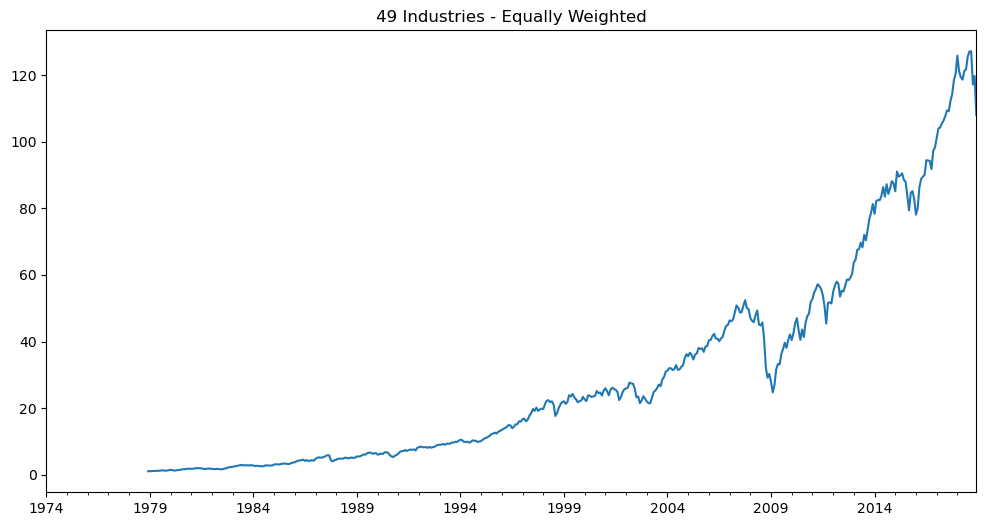

In [ ]:
ewr = rk.backtest_ws(ind49_rets, weighting = rk.weight_ew)
ewi = (1+ewr).cumprod()
ewi.plot(figsize=(12,6), title="49 Industries - Equally Weighted")

Now, let's add capweighting. We'll need to compute capweights, which we've already been provided through the marketcap file. We can refactor the code we've developed in the past to add a convenience function to our toolkit. Note the use of `**kwargs` to be able to take a variable number of keyword arguments to the function so that we can call any weighting function and let that weighting function take care of whatever arguments it needs. We'll have to refactor `weight_ew` with this new signature, but thats the only change (for now) for `weight_ew`.

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.123921,0.052514,-0.759092,6.659028,0.071404,0.102331,1.740165,-0.528292
CW,0.119761,0.048265,-0.726933,5.621768,0.065773,0.093909,1.809587,-0.516647


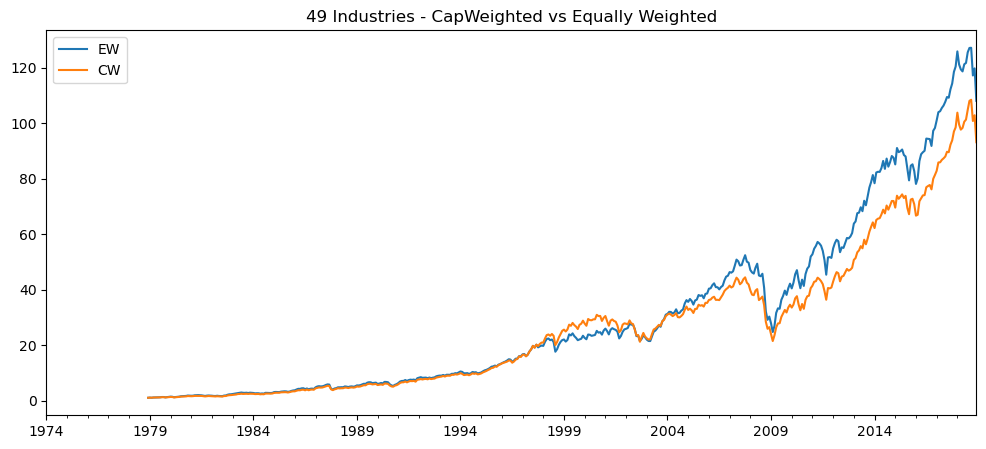

In [ ]:
ewr = rk.backtest_ws(ind49_rets)
cwr = rk.backtest_ws(ind49_rets, weighting=rk.weight_cw, cap_weights=ind49_mcap)
btr = pd.DataFrame({"EW": ewr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,5), title="49 Industries - CapWeighted vs Equally Weighted")
rk.summary_stats(btr.dropna())

# Improving EW with CapWeight Tethering

Often in practice, we'll want to implement some sort of a modification of a pure strategy. For instance, although Equal Weight portfolios are popular, they'll be constrained in some way - for instance to match the sector weights of the cap-weighted benchmark or to make sure that microcap stocks are not overweighted. The motivation for doing so could be to make a portfolio more tradeable (e.g. some microcaps may not have the liquidity) or to improve the tracking error to the Cap-Weighted index.

As an illustration of how that can be achieved, we enhance our simple `weight_ew` allocator to (i) drop microcap stocks beyond a particular threshold, and (ii) impose a constraint that ensures that the maximum weight assigned to any stock is no more than some multiple of the weight it would be in a cap-weighted portfolio.


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.123921,0.052514,-0.759092,6.659028,0.071404,0.102331,1.740165,-0.528292
EW-Tethered,0.125572,0.051293,-0.752967,6.187433,0.069778,0.099191,1.812973,-0.530654
CW,0.119761,0.048265,-0.726933,5.621768,0.065773,0.093909,1.809587,-0.516647


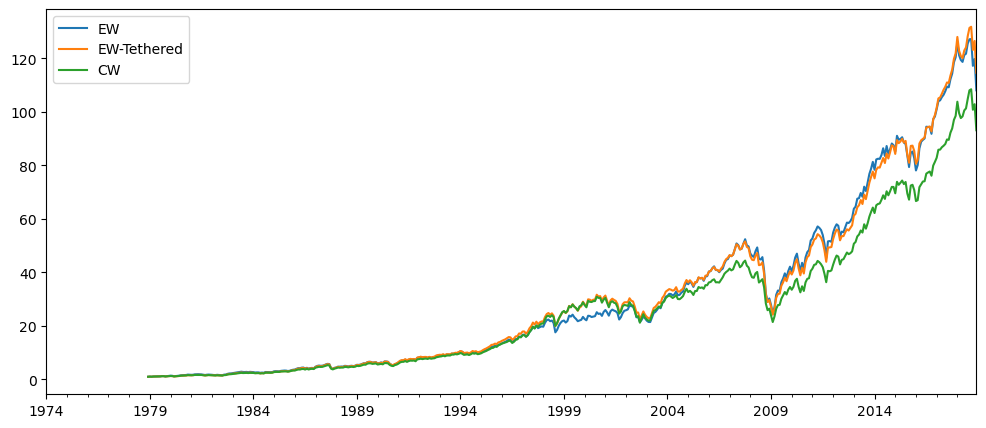

In [ ]:
ewr = rk.backtest_ws(ind49_rets)
ewtr = rk.backtest_ws(ind49_rets, cap_weights=ind49_mcap, max_cw_mult=5, microcap_threshold=.005)
cwr = rk.backtest_ws(ind49_rets, weighting=rk.weight_cw, cap_weights=ind49_mcap)
btr = pd.DataFrame({"EW": ewr, "EW-Tethered": ewtr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,5))
rk.summary_stats(btr.dropna())